In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, FunctionTransformer
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, log_loss

In [2]:
df = pd.read_csv('train.csv')
df

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,2178.0,D-penicillamine,16374.0,F,N,N,N,N,0.5,263.0,3.20,43.0,1110.0,106.95,67.0,430.0,9.6,3.0,C
1,1,2644.0,D-penicillamine,17774.0,F,N,N,N,N,0.8,280.0,3.60,22.0,678.0,62.00,80.0,427.0,13.0,3.0,C
2,2,3069.0,Placebo,17844.0,F,N,N,N,N,1.1,408.0,4.40,54.0,2108.0,142.60,137.0,203.0,10.6,3.0,C
3,3,2216.0,Placebo,19221.0,F,N,Y,Y,N,0.8,252.0,3.70,36.0,843.0,55.80,56.0,336.0,9.6,4.0,C
4,4,2256.0,Placebo,21600.0,F,N,N,N,N,4.7,348.0,3.06,464.0,961.0,120.90,146.0,298.0,11.0,2.0,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,1783.0,Placebo,23107.0,F,N,Y,N,S,1.3,243.0,3.76,58.0,944.0,97.00,93.0,233.0,9.9,4.0,C
14996,14996,3492.0,NaN,13149.0,F,NaN,NaN,NaN,N,0.7,NaN,4.03,NaN,NaN,NaN,NaN,273.0,10.3,2.0,C
14997,14997,1170.0,NaN,22646.0,F,NaN,NaN,NaN,N,0.8,NaN,3.14,NaN,NaN,NaN,NaN,280.0,10.6,3.0,C
14998,14998,1433.0,Placebo,21828.0,F,N,N,N,N,0.6,280.0,4.04,52.0,843.0,28.38,189.0,334.0,10.0,2.0,C


# 1. EDA

In [3]:
df.info()       # tonns of missing values

<class 'pandas.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15000 non-null  int64  
 1   N_Days         15000 non-null  float64
 2   Drug           8494 non-null   str    
 3   Age            15000 non-null  float64
 4   Sex            15000 non-null  str    
 5   Ascites        8502 non-null   str    
 6   Hepatomegaly   8492 non-null   str    
 7   Spiders        8491 non-null   str    
 8   Edema          15000 non-null  str    
 9   Bilirubin      15000 non-null  float64
 10  Cholesterol    6701 non-null   float64
 11  Albumin        15000 non-null  float64
 12  Copper         8399 non-null   float64
 13  Alk_Phos       8488 non-null   float64
 14  SGOT           8486 non-null   float64
 15  Tryglicerides  6666 non-null   float64
 16  Platelets      14436 non-null  float64
 17  Prothrombin    14984 non-null  float64
 18  Stage          15

In [4]:
df.drop('id', axis=1).duplicated().sum()    # exist 6 duplicated rows

np.int64(6)

In [5]:
df.drop_duplicates(subset=df.columns.difference(['id']), inplace=True)      # dropping duplicates

In [6]:
df.describe()

,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,14994.000000,14994.000000,14994.000000,14994.000000,6701.000000,14994.000000,8399.000000,8488.000000,8486.000000,6666.000000,14430.000000,14978.000000,14994.000000
mean,7498.530412,1971.785247,19297.952314,1.845885,329.177302,3.526123,75.647339,1618.598233,106.483631,111.387886,252.889051,10.626195,3.025010
std,4330.029372,1333.915494,3797.609823,2.675298,180.320802,0.372313,74.830472,1767.240078,57.206017,55.056133,94.052400,0.731534,0.871127
min,0.000000,3.000000,400.000000,0.200000,120.000000,0.500000,2.000000,3.400000,0.900000,19.000000,32.000000,9.000000,1.000000
25%,3749.250000,1095.000000,16658.000000,0.600000,242.000000,3.290000,31.000000,720.000000,71.000000,80.000000,181.000000,10.100000,2.000000
50%,7498.500000,1786.000000,19544.000000,0.900000,280.000000,3.580000,52.000000,1072.000000,97.650000,99.000000,248.000000,10.600000,3.000000
75%,11247.750000,2635.000000,22347.000000,1.800000,364.000000,3.770000,89.000000,1664.000000,130.200000,133.000000,311.000000,11.000000,4.000000
max,14999.000000,38320.000000,129398.000000,28.000000,2078.000000,4.640000,662.000000,13862.400000,2653.000000,1669.000000,1024.000000,18.000000,4.000000


`Age` column is in days

`N_Days` represents how long the patient was observed until the outcome occurred. This information is not available at the time of prediction, because clinicians cannot wait for several days to see what happens before making a prediction. Additionally, the class **C (censored)** only means the patient was alive at last follow-up, not that they will remain alive indefinitely. Therefore, `N_Days` should be removed from the model to ensure predictions are based only on information available at baseline.


In [7]:
df.Status.value_counts()       # target feature is highly imbalanced, and has one wrong value

Status
C     10047
D      4565
CL      381
Y         1
Name: count, dtype: int64

In [8]:
df = df[df.Status != 'Y']

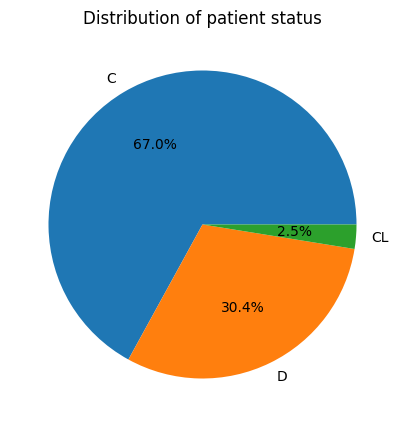

In [9]:
survival_rate = df['Status'].value_counts() / len(df) * 100             # 67/30 majority/priority rate

plt.figure(figsize=(5,5))
plt.pie(survival_rate, labels = ['C', 'D', 'CL'], autopct='%1.1f%%')
plt.title('Distribution of patient status')
plt.show()

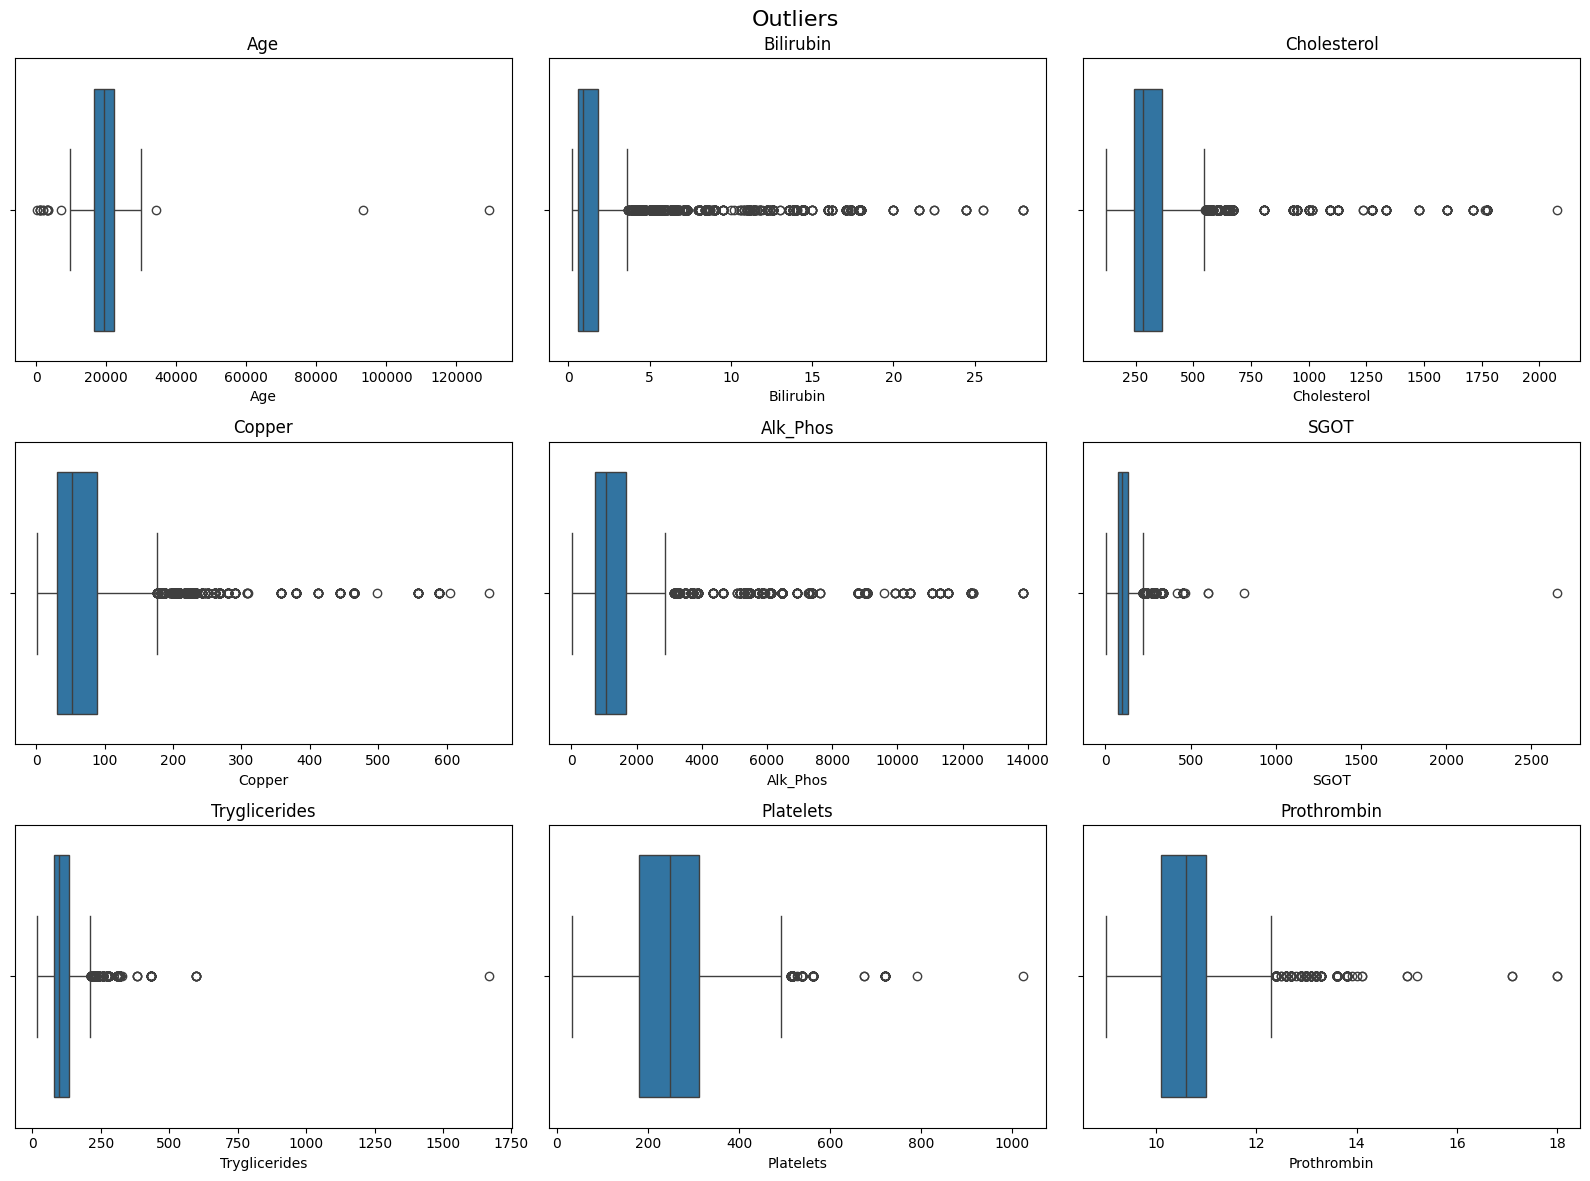

In [10]:
cols = ['Age', 'Bilirubin', 'Cholesterol', 'Copper', 'Alk_Phos',
        'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
fig.suptitle('Outliers', fontsize=16)

for ax, col in zip(axes.flatten(), cols):
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()


Outliers are to be capped inside pipeline during training

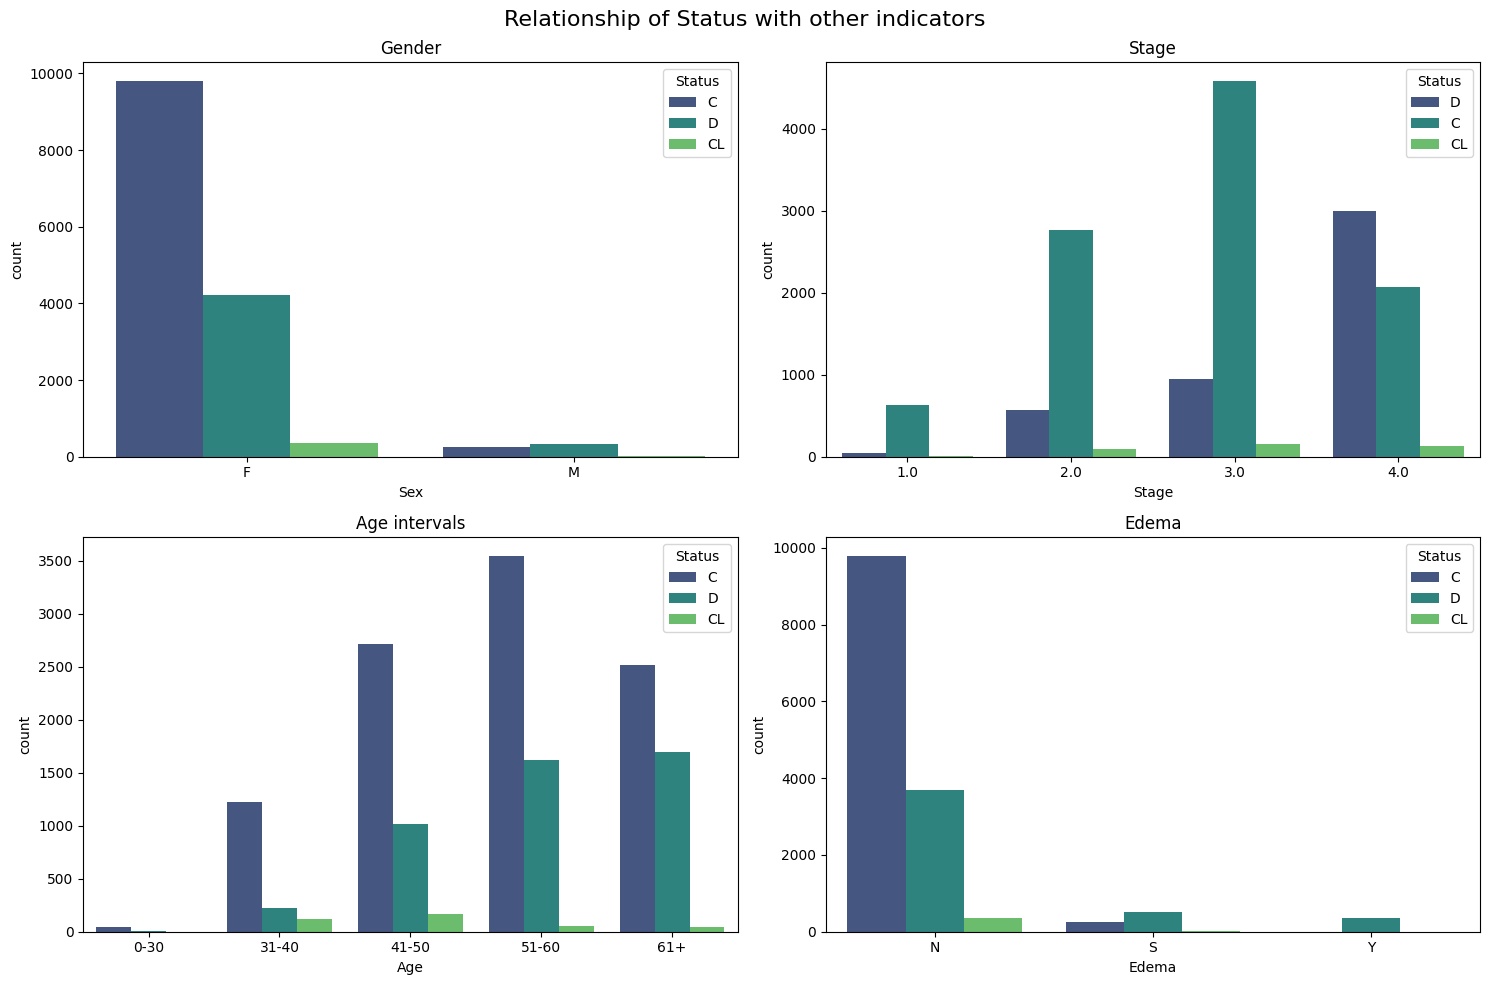

In [11]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
fig.suptitle('Relationship of Status with other indicators', fontsize=16)

sns.countplot(x='Sex', hue='Status', palette='viridis', data=df, ax=axes[0,0])
axes[0,0].set_title('Gender')

sns.countplot(x='Stage', hue='Status', palette='viridis', data=df, ax=axes[0,1])
axes[0,1].set_title('Stage')

bins=[0, 30, 40, 50, 60, 120]
labels = ["0-30", "31-40", "41-50", '51-60', "61+"]
sns.countplot(x=pd.cut(df['Age']/365, bins=bins, labels=labels), hue=df['Status'], palette='viridis', ax=axes[1,0])
axes[1,0].set_title('Age intervals')

sns.countplot(x='Edema', hue='Status', palette='viridis', data=df, ax=axes[1,1])
axes[1,1].set_title('Edema')

plt.tight_layout()
plt.show()

- Higher disease stage and older age are associated with a higher risk of death
- The dataset is heavily imbalanced with respect to gender

# 2. Model

In [12]:
X = df.drop('Status', axis=1)

le = LabelEncoder()
y = le.fit_transform(df.Status.copy())

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The dataset contains many missing and abnormal values (e.g., extreme age or lab measurements), but the test set also includes such cases. LightGBM is used because it handles missing values internally and can still make predictions on incomplete or noisy data. If higher-quality data becomes available, the model can be retrained to improve performance.

In [14]:
def cap_outliers(x):
    """Cap outliers"""

    x['Age'] = x['Age'].clip(upper=43_800)                  # 120*365=43800 days

    x['Bilirubin'] = x['Bilirubin'].clip(upper=20)     

    x['Cholesterol'] = x['Cholesterol'].clip(upper=700)

    x['Copper'] = x['Copper'].clip(upper=300)

    x['Alk_Phos'] = x['Alk_Phos'].clip(upper=8000)

    x['SGOT'] = x['SGOT'].clip(upper=500)

    x['Tryglicerides'] = x['Tryglicerides'].clip(upper=400)

    x['Platelets'] = x['Platelets'].clip(upper=600)

    return x.drop(['N_Days'], axis=1)

cap_features = FunctionTransformer(cap_outliers, validate=False)

categorical_cols = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols)
    ], remainder='passthrough'      # pass numerical features to pipeline
    )

In [15]:
print(le.classes_)

['C' 'CL' 'D']


In [16]:
weights = {0: 1, 1: 1, 2: 67/30}        # ratio of majority/priority class for class_weight to address class imbalance

In [17]:
# LGBM handles missing values

pipeline = Pipeline([
    ('cap_outliers', cap_features),
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(
        objective='multiclass',
        num_class=3,
        class_weight=weights
        ))
])

In [18]:
pipeline.fit(X_train, y_train)                  # training model

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1923
[LightGBM] [Info] Number of data points in the train set: 11994, number of used features: 18
[LightGBM] [Info] Start training from score -0.714790
[LightGBM] [Info] Start training from score -4.033202
[LightGBM] [Info] Start training from score -0.707271


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('cap_outliers', ...), ('preprocessor', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function cap...0018D834F1300>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword argume

# 3. Model evaluation

In [19]:
print(le.classes_)

['C' 'CL' 'D']


c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


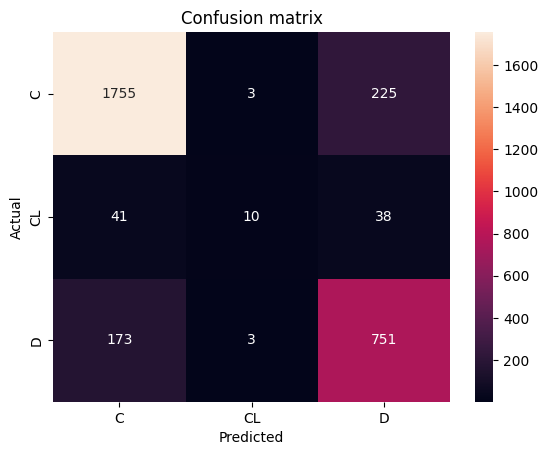

In [20]:
y_pred = pipeline.predict(X_test)
labels = ['C','CL','D']
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, xticklabels=labels, yticklabels=labels, fmt='d', annot=True)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The model produced 176 false negatives, meaning 176 patients who died were incorrectly predicted as alive.

In [21]:
y_pred_proba = pipeline.predict_proba(X_test)

c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [22]:
loss = log_loss(y_test, y_pred_proba)
confidence = np.exp(-0.42)

print(f'Logarithmic loss: {loss:.4f}')
print(f'Confidence: {confidence:.4f}')

Logarithmic loss: 0.4266
Confidence: 0.6570


The average predicted probability for the true class is approximately 0.66, indicating moderate confidence.

# 4. Test

In [23]:
df_test = pd.read_csv('test.csv')
df_test

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,15000,22646.0,NaN,22646.0,F,NaN,NaN,NaN,N,1.4,NaN,3.34,NaN,NaN,NaN,NaN,190.0,11.0,4.0
1,15001,2149.0,NaN,18993.0,F,NaN,NaN,NaN,N,0.9,NaN,3.24,NaN,NaN,NaN,NaN,233.0,9.0,2.0
2,15002,3850.0,D-penicillamine,16050.0,M,N,N,N,N,1.0,460.0,3.64,75.0,2148.0,102.30,118.0,172.0,10.6,3.0
3,15003,2419.0,D-penicillamine,20354.0,F,N,N,N,N,0.6,258.0,3.96,31.0,642.0,70.00,83.0,336.0,10.8,2.0
4,15004,1086.0,NaN,23376.0,F,NaN,NaN,NaN,N,4.4,NaN,4.40,NaN,NaN,NaN,NaN,447.0,10.3,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,2106.0,Placebo,16728.0,F,N,N,N,N,1.1,1128.0,3.35,91.0,815.0,127.10,166.0,421.0,9.6,1.0
9996,24996,186.0,D-penicillamine,13073.0,M,N,Y,N,N,0.6,267.0,3.02,225.0,728.0,120.90,90.0,142.0,12.3,4.0
9997,24997,3458.0,D-penicillamine,20296.0,F,N,N,N,N,0.9,NaN,3.35,136.0,1995.0,128.00,NaN,243.0,10.6,2.0
9998,24998,2891.0,D-penicillamine,20254.0,F,N,N,N,N,0.8,NaN,3.75,63.0,674.0,26.35,NaN,325.0,10.0,1.0


In [24]:
survival_rate = pipeline.predict_proba(df_test)

c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [25]:
df_predict = pd.read_csv('sample_submission.csv')
df_predict

,id,Status_C,Status_CL,Status_D
0,15000,0.628084,0.034788,0.337128
1,15001,0.628084,0.034788,0.337128
2,15002,0.628084,0.034788,0.337128
3,15003,0.628084,0.034788,0.337128
4,15004,0.628084,0.034788,0.337128
...,...,...,...,...
9995,24995,0.628084,0.034788,0.337128
9996,24996,0.628084,0.034788,0.337128
9997,24997,0.628084,0.034788,0.337128
9998,24998,0.628084,0.034788,0.337128


In [26]:
df_predict['Status_C'] = survival_rate[:,0]
df_predict['Status_CL'] = survival_rate[:,1]
df_predict['Status_D'] = survival_rate[:,2]
df_predict

,id,Status_C,Status_CL,Status_D
0,15000,0.328718,0.023851,0.647432
1,15001,0.921401,0.004017,0.074582
2,15002,0.617494,0.013662,0.368844
3,15003,0.994986,0.000165,0.004849
4,15004,0.207196,0.027984,0.764820
...,...,...,...,...
9995,24995,0.922931,0.015556,0.061514
9996,24996,0.150694,0.002773,0.846533
9997,24997,0.924627,0.005730,0.069643
9998,24998,0.986968,0.000065,0.012967


In [27]:
df_predict.to_csv('cirrhosis_survival_rate.csv', index=False)